# Checking Variation of Photobleaching 

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.image
import pboc.plotting
import pboc.mcmc
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.measure
import skimage.morphology
import scipy.optimize
import mwc_growth as mwc
import matplotlib.pyplot as plt
import glob
import sys
sys.path.insert(0, '../')
import mwc.plotting
import mwc.image
import bokeh.io
%matplotlib inline
bokeh.io.output_notebook()

Loading BokehJS ...

## The problem

My missing factor of five may be coming from variation in the laser intensity from frame to frame. Just by looking at fluctuations, I wouldn't be able to see that as the partitioning of the proteins is another confounding factor to intensity values. However, I could look at single cells from time point to time point from a bleaching movie to see the fluorescence change and correct for photobleaching.  

### First, some image processing

I first need to load in the image data and perform the segmentation.   

In [179]:
import imp
imp.reload(pboc.plotting)

<module 'pboc.plotting' from '/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/pboc-py/pboc/plotting.py'>

In [404]:
# Define the data directory.
data_dir = '../data/images/20180111_37C_glucose_O2_dilution/'

# Choose the third run of the delta strain.
ome = glob.glob('{0}photobleaching/*delta*/*.tif'.format(data_dir))
ome = np.sort(ome)
# Load the image into Python
ome_ims = skimage.io.ImageCollection(ome[0])

# Split them by phase and fluorescence.
phase = ome_ims[0]

# Get the fluorescence ims
fluo_orig = ome_ims[1::2]

In [405]:
print(ome[2])

../data/images/20180111_37C_glucose_O2_dilution/photobleaching/20180111_snaps_deltaTetR_0ngmL_3/20180111_snaps_deltaTetR_0ngmL_3_MMStack_Pos0.ome.tif


In [406]:
# Flatten all of the fluorescence images.
slide = skimage.io.ImageCollection('{0}**/*TRITC*/Pos*/*.tif'.format(data_dir))
mean_slide = pboc.image.projection(slide, 'mean', median_filt=False)
zeros = np.zeros_like(phase)
fluo_ims = [pboc.image.generate_flatfield(im, zeros, mean_slide, median_filt=False) for im in fluo_orig]

In [407]:
p1 = pboc.plotting.imshow(phase, plot_height=300)
p2 = pboc.plotting.imshow(fluo_ims[1], plot_height=300)
p3 = pboc.plotting.imshow(fluo_ims[-1], plot_height=300)
p1.title.text = 'phase image'
p2.title.text = 'fluorescence image, t = 0'
p3.title.text = 'fluorescence image, t = end'
row = bokeh.layouts.row([p1, p2, p3])
bokeh.io.show(row)

Now perform the segmentation using the thresholding method. 

In [408]:
def threshold_phase(im, min_int=0.15):
    """
    Performs an intensity based segmentation of a phase contrast image.
    This function uses Otsu's method to determine the threshold value.

    Parameters
    ----------
    im: 2d-array
        Image to be segmented. Desired objects in this image are assumed
        to be dark.
    min_int : float
        The maximum mean pixel intensity of a segmented object. This
        value must be between 0 and 1. Default is 0.15

    Returns
    -------
    mask: 2d-array, int
        Segmented image with labeled regions.
    """

    # Preprocess the phase image.
    im_float = (im - im.min()) / (im.max() - im.min())

    # Use Otsu's method.
    thresh = skimage.filters.threshold_otsu(im_float)

    # Clean initial segmentation.
    seg = skimage.segmentation.clear_border(im_float < thresh)
    seg = skimage.morphology.remove_small_objects(seg)
    mask = skimage.measure.label(seg)

    # Oversegment to correct for slight drift.
    selem = skimage.morphology.disk(2)
    mask = skimage.morphology.dilation(mask, selem)
    lab = skimage.measure.label(mask)

    # Impose minimum intensity filter.
    props = skimage.measure.regionprops(lab, im_float)
    final_im = np.zeros_like(mask)
    for prop in props:
        mean_int = prop.min_intensity
        if mean_int <= min_int:
            final_im += (lab == prop.label)
    mask = skimage.measure.label(final_im)
    return mask





In [409]:
# Perform the segmentation
seg = threshold_phase(phase)

p = pboc.plotting.imshow(seg)
bokeh.io.show(p)

Looks good enough to me! Now extract the intensities for a single cell (and the background) over time. 


In [410]:
col_names = ['cell_id', 'area', 'total_intensity',
             'frame_no', 'mean_bg']
bleaching_df = pd.DataFrame([], columns=col_names)
max_cell = np.max(seg)
time = 0
for i, fluo in enumerate(fluo_ims):
    bg_mean = np.mean(fluo[seg==0])
    props = skimage.measure.regionprops(seg, fluo)
    for p in props:
        cell_id = p.label
        cell_area = p.area
        cell_int = p.mean_intensity * cell_area
        bleaching_df = bleaching_df.append(dict(cell_id=cell_id, area=cell_area, total_intensity=cell_int,
                                               mean_bg=bg_mean, frame_no=time), ignore_index=True) 
    time += 1

### Correcting for photobleaching 

I should plot the photobleaching curve

In [411]:
grouped = bleaching_df.groupby(['cell_id'])

# Set up the figure. 
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='intensity')
for g, d in grouped:
    p.line(x='frame_no', y='total_intensity', source=d, alpha=0.5)

bokeh.io.show(p)

It looks like something went wrong around frame 200. We can cut off all the data from this point onward.

In [412]:
# Exclude shifted frames.
# trimmed = bleaching_df.copy() 
trimmed = bleaching_df[bleaching_df['frame_no'] < 200]

In [413]:
# Plot the bg fluorescence. 
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='raw intensity')
p.line('frame_no', 'mean_bg', source=trimmed)
bokeh.io.show(p)


## Fitting to photobleaching

I'll assume a single exponential decay model for this data, which is probably going to be okay. I'll normalize the cell traces to an average and then fit. 

In [414]:
grouped = trimmed.groupby(['cell_id'])
vec = np.zeros((int(np.max(trimmed['cell_id'])), len(trimmed['frame_no'].unique())))
for g, d in grouped:
    sorted_d = d.sort_values(['frame_no'])
    vec[int(g)-1, :] = d['total_intensity'] / d.iloc[0]['total_intensity']
avg = np.mean(vec, axis=0)

In [415]:
# Plot the traces and the average. 
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='normalized intensity')
for v in vec:
    p.line(trimmed['frame_no'].unique(), v, color='slategray', alpha=0.5)
p.line(trimmed['frame_no'].unique(), avg, color='tomato')
bokeh.io.show(p)

It looks like there was a hiccup at frame two -- probably a camera streaming error. We'll just drop this position from the average.  

In [416]:
# Make a new dataframe
avg_df = pd.DataFrame(np.array([avg, trimmed['frame_no'].unique()]).T, columns=['avg', 'frame'])
avg_df = avg_df[avg_df['frame'] != 1]

In [417]:
# Plot the dataframe to see how well it works.
p = pboc.plotting.boilerplate(x_axis_label='frame', y_axis_label='fractional intensity')
p.line('frame', 'avg', source=avg_df)
p.circle('frame', 'avg', source=avg_df)
bokeh.io.show(p)

Looks okay. Let's now fit it to a single exponential. I'll use MCMC for this. 

In [418]:
with pm.Model() as model:
    tau = pm.HalfFlat('tau')
    sigma = pm.HalfNormal('sigma', sd=1)
    beta = pm.Uniform('beta', lower=0, upper=1)
    
    # Compute the exponential value.
    time = avg_df['frame'].values
    mu = beta * np.exp(-time / tau)
    
    # Sample.
    like = pm.Normal('like', mu=mu, sd=sigma, observed=avg_df['avg'].values)
    trace = pm.sample(draws=5000, tune=5000, njobs=4) 
    trace_to_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_to_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_interval__, sigma_log__, tau_log__]
100%|██████████| 10000/10000 [00:11<00:00, 901.38it/s]
The acceptance probability does not match the target. It is 0.711802534821, but should be close to 0.8. Try to increase the number of tuning steps.


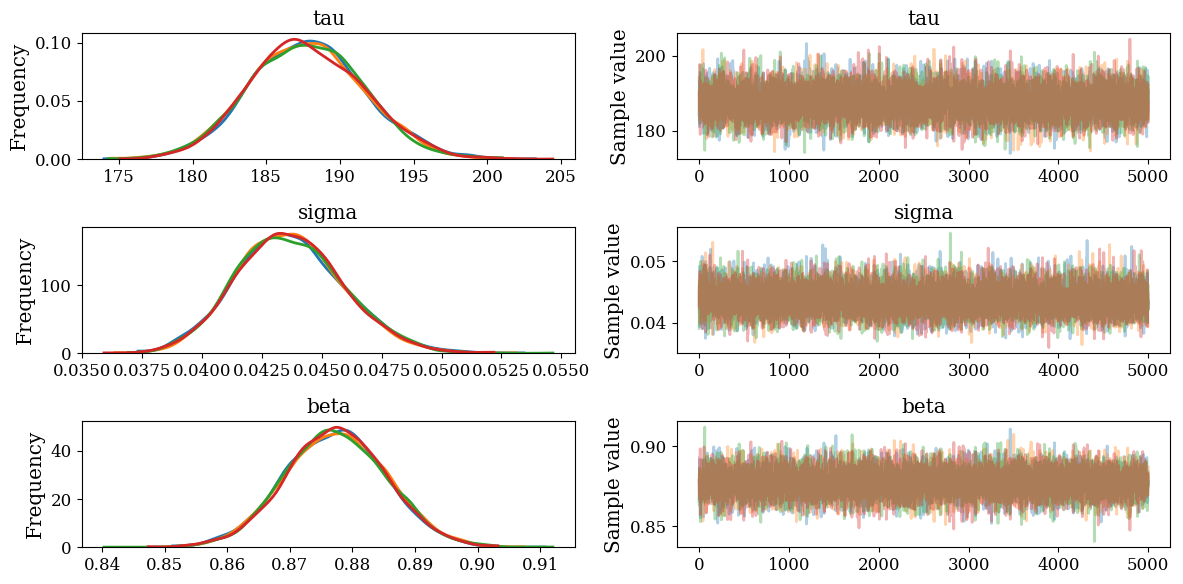

In [419]:
_ = pm.traceplot(trace)

Now we can extract the parameter values and look at the fit 

In [420]:
# Convert the parameter values to a dict
stat_dict = {i:j for i, j in zip(stats['parameter'].values, stats['mode'].values)}
                                 
# Compute the fit
time_range = np.linspace(0, 200, 500)
fit = stat_dict['beta'] * np.exp(-time_range / stat_dict['tau'])

# Plot everything together. 
p = pboc.plotting.boilerplate(x_axis_label='frame', y_axis_label='normalized intensity')
p.circle('frame', 'avg', source=avg_df)
p.line(time_range, fit, color='tomato')
bokeh.io.show(p)           

I think we can do better than that. Fit it using optimization with a biexponential decay. 

In [421]:
guess = [0, 0.5,  10, 0.5, 20]
popt = scipy.optimize.minimize(mwc.log_posterior_biexp, guess, method='Powell', args=(avg_df['frame'], avg_df['avg'], True))
bg, beta_1, tau_1, beta_2, tau_2 = popt.x

In [422]:
# Plot another fit
fit_biexp = bg + beta_1 * np.exp(-time_range / tau_1) + beta_2 * np.exp(-time_range / tau_2)

p = pboc.plotting.boilerplate(x_axis_label='frame', y_axis_label='normalized_intensity')
p.circle('frame', 'avg', source=avg_df, color='slategray')
p.line(time_range, fit, color='tomato', legend='single exp')
p.line(time_range, fit_biexp, color='dodgerblue', legend='biexponential')
bokeh.io.show(p)

Okay, the biexponential is a great fit. I'll use that.  

### Correcting for photobleaching 

Now we can correct each individual cell intensity using the single exponential fit

In [423]:
def correction(time, betas, taus, bg, orig_value):
    fraction = bg + betas[0] * np.exp(-time / taus[0]) + betas[1] * np.exp(-time / taus[1])
    return orig_value / fraction 

In [428]:
# Remove the annoying frame.
cell_df = trimmed.copy()

# Correct the intensity.
cell_df.loc[:, 'corrected_intensity'] = correction(cell_df['frame_no'], [beta_1, beta_2], [tau_1, tau_2], bg,
                                                   cell_df['total_intensity'])

Now plot the corrected dtaframe

In [429]:
grouped = cell_df.groupby('cell_id')
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='corrected intensity')

for g, d in grouped:
    p.line('frame_no', 'corrected_intensity', source=d)
bokeh.io.show(p)

Obviously there's some issue here from the fitting, but it's more or less flat. It looks like there is some periodicity in the trace! Let's go through and compute the derivative divided by the x - 1 value.

In [430]:
fraction = np.zeros((int(np.max(cell_df['cell_id'])), len(cell_df['frame_no'].unique()) - 1))
values = np.zeros(((int(np.max(cell_df['cell_id'])), len(cell_df['frame_no'].unique()))))
for g, d in grouped:
    sorted_d = d.sort_values('frame_no')['corrected_intensity']
    ddf = np.diff(sorted_d)
    fraction[int(g) - 1, :] = ddf / sorted_d.iloc[:-1]
    values[int(g) -1 , :]  = sorted_d / sorted_d.max()


In [431]:
# Plot the absolute value of each as a function of frame number
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='percent change',
                             plot_width=900)
for f in fraction:
    p.line(cell_df['frame_no'].unique()[:-1], f, alpha=0.5)
avg_perc = np.mean(fraction, axis=0)
p.line(cell_df['frame_no'].unique()[:-1], avg_perc, color='tomato', line_width=2)
bokeh.io.show(p)

In [432]:
def power_spectrum(signal, sampling_freq):
    """
    Computes the powerspectrum of a signal.
    """
    length = len(signal)
    vec = np.arange(length)
    
    # Define the frequency range.
    total_time = length / sampling_freq
    frequency = vec / total_time
    frequency = frequency[range(int(length / 2))]
    
    # Compute the fourier tranform and normalize.
    fft = np.fft.fft(signal) / length
    fft = fft[range(int(length / 2))]
    return frequency, fft
    

Compute the power spectrum for just the intensity fluctuations. 

In [433]:
np.mean(np.abs(avg_perc)) * 100

2.4406009375529738

In [332]:

ddf = np.diff(corrected_bg)
bg_fraction = ddf / corrected_bg[:-1]

In [335]:
p = pboc.plotting.boilerplate()
p.line(cell_df['frame_no'].unique(), corrected_bg)
bokeh.io.show(p)

/Users/gchure/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 200), ('y', 3600)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [333]:
# Plot the absolute value of each as a function of frame number
p = pboc.plotting.boilerplate(x_axis_label='frame number', y_axis_label='percent change',
                             plot_width=900)
p.line(cell_df['frame_no'].unique()[:-1], bg_fraction, color='tomato', line_width=2)
p.title.text = 'background'
bokeh.io.show(p)

/Users/gchure/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 199), ('y', 3599)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
